In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.decomposition import PCA

# Data Import and EDA

In [214]:
df=pd.read_excel('Online Retail.xlsx')

In [215]:
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       -----------

In [216]:
# remove null data for description and customer ID
df.dropna(how='any',inplace=True)
#only interested in UK data
df=df[df['Country']=='United Kingdom']
#remove cancelled orders
df=df[df['InvoiceNo']!='C%']
#remove data with negative quantity and price
df=df[(df['Quantity']>0) & (df['UnitPrice']>0)]
#only looking at data between 11 Dec 2010 to 10 Dec 2011
df=df[(df['InvoiceDate']>='2010-12-11')&(df['InvoiceDate']<='2011-12-10')]
#create revenue column
df['Revenue']=df['Quantity']*df['UnitPrice']


In [217]:
#categorical data
df['CustomerID'] = pd.Categorical(df['CustomerID'].astype(int))
df['StockCode'] = pd.Categorical(df['StockCode'])
#new columns
df['Revenue']=df['Quantity']*df['UnitPrice']
df['InvoiceDay'] = df.InvoiceDate.apply(lambda x: dt.datetime(x.year, x.month, x.day))

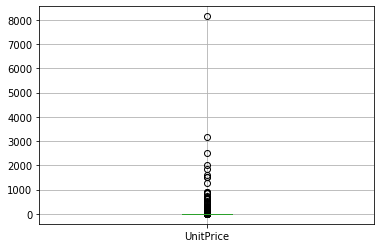

In [218]:
df.boxplot(column=['UnitPrice'], return_type='axes');

In [219]:
df.to_csv("OnlineRetail_Filtered.csv", index=False)

# Perfom customer segmentation using RFM(Recency,Frequncy,Monetary) analysis.

In [220]:
#create a ref date
ref_date = max(df.InvoiceDay) + dt.timedelta(1)
#groupby customer ID, where InvoiceNo is count of frequency, revenue is monetary and InvoiceDay is recency
rfm=df.groupby('CustomerID').agg({'InvoiceNo': 'count',
                             'Revenue': 'sum',
                             'InvoiceDay': lambda x: ref_date-x.max()})
rfm.rename(columns={'InvoiceNo': 'Frequency',
            'Revenue': 'Monetary',
            'InvoiceDay': 'Recency'},inplace=True)

In [221]:
rfm.head()
rfm['Recency'] = rfm['Recency'].dt.days

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020F8DD19DC8>,
      dtype=object)

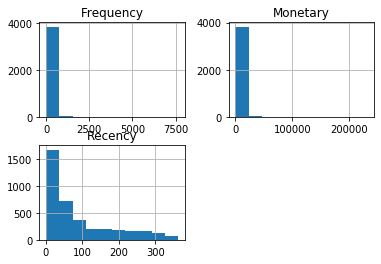

In [222]:
rfm.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020F90CB2108>,
      dtype=object)

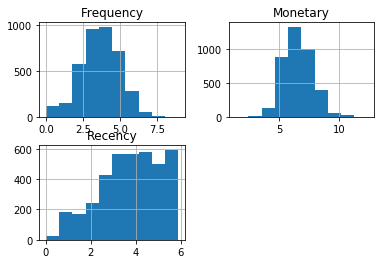

In [223]:
#normalize data
rfm_log=rfm.apply(np.log,axis=1)
rfm_log.hist()

In [224]:
#generate elbow plot for ideal k 
inertia=[]
for k in range(1,11):
    model=KMeans(k)
    model.fit(rfm_log)
    inertia.append(model.inertia_)

Text(0, 0.5, 'Inertia')

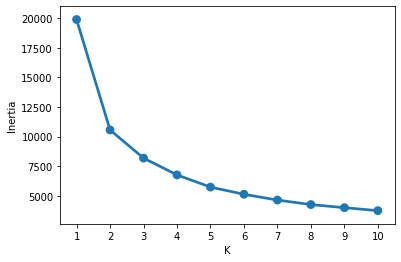

In [225]:
#plot elbowplot
sns.pointplot(x=list(range(1,11)),y=inertia)
plt.xlabel('K')
plt.ylabel('Inertia')

In [226]:
model=KMeans(n_clusters=3)
labels=model.fit_predict(rfm_log)
rfm_log['labels']=labels

In [227]:
rfm_log_exp=rfm_log[['Frequency','Monetary','Recency']].apply(np.exp,axis=1)

In [228]:
rfm_log_exp['labels']=labels
rfm_log_exp.head()

,Frequency,Monetary,Recency,labels
CustomerID,,,,
12346,1.0,77183.60,326.0,1
12747,96.0,3837.45,3.0,2
12748,4051.0,30301.40,1.0,2
12749,199.0,4090.88,4.0,2
12820,59.0,942.34,4.0,2


In [229]:
rfm_log.describe()

,Frequency,Monetary,Recency,labels
count,3849.000000,3849.000000,3849.000000,3849.000000
mean,3.647189,6.528944,3.759722,0.882307
std,1.328443,1.240683,1.364555,0.747429
min,0.000000,1.321756,0.000000,0.000000
25%,2.772589,5.680514,2.890372,0.000000
50%,3.688879,6.465834,3.912023,1.000000
75%,4.574711,7.346101,4.897840,1.000000
max,8.943898,12.353728,5.894403,2.000000


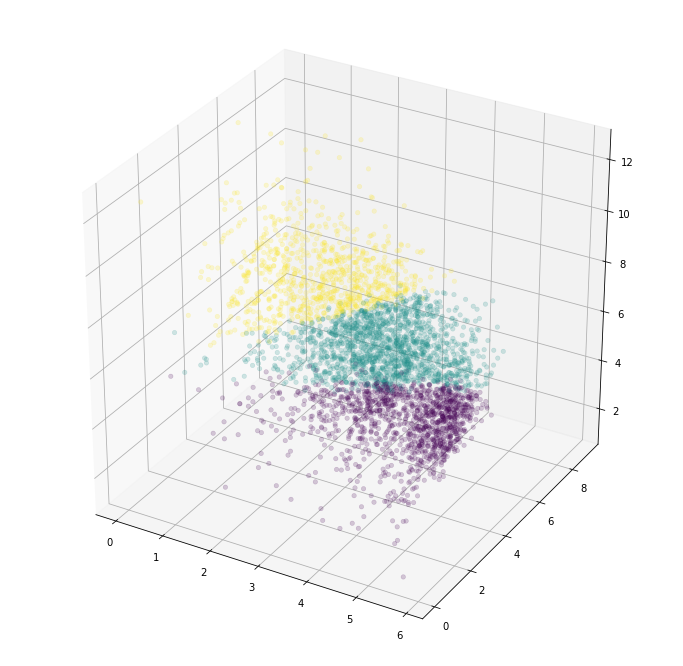

In [230]:
#Visualise results, 3d
fig=plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.scatter(rfm_log.Recency, rfm_log.Frequency, 
                        rfm_log.Monetary, c=rfm_log.labels,
                        cmap='viridis', linewidth=0.5, alpha=0.2);
plt.show()

In [231]:

pca = PCA(n_components=2)
pca.fit(rfm_log)
rfm_pca2 = pca.transform(rfm_log)

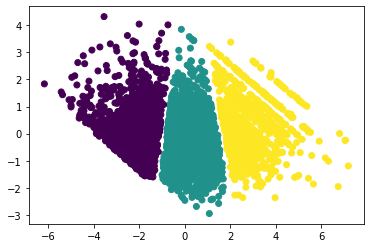

In [232]:
#visualise 2d
plt.scatter(x=rfm_pca2[:,0],y=rfm_pca2[:,1],c=rfm_log['labels'])

In [233]:
cluster_centroids = pd.DataFrame(model.cluster_centers_, columns=[ 'Frequency', 'Monetary','Recency']).apply(np.exp, axis = 1).round(3)

In [234]:
cluster_centroids

,Frequency,Monetary,Recency
0,10.314,219.878,120.548
1,51.788,807.617,45.932
2,160.829,2821.949,7.877


In [235]:
#0:small customers,1: medium, 2: large
#extract small &large customers
rfm_large=rfm_log[rfm_log['labels']==2].apply(np.exp, axis = 1).round(3)
rfm_small=rfm_log[rfm_log['labels']==0].apply(np.exp, axis = 1).round(3)

In [237]:
rfm_large.to_csv("LargeCustomers.csv", index=True)
rfm_small.to_csv("SmallCustomers.csv", index=True)